# Final Project

# Name: Yijin Lu
    
Website: https://www.kickstarter.com

Data source (link to download): https://www.kaggle.com/kemical/kickstarter-projects       

## Data and Problem Summary

### Dataset: 
Kickstar Projects

### Motivation: 
Our project will include an analysis of data from Kickstarter, a crowdfunding website. The motivation behind our project will include:
- Analyzing which category is associated with successful campaigns.
- Finding the best prediction model of precise prediction.
- Assessing characteristics of successful projects.

Overall, our exploration and assessment of the dataset will help project owners on Kickstarter to make wise decisions on how to raise money and sustain the success of their projects on Kickstarter.


### Questions addressing:
- Exploratory
    - Visualize the successful/failed projects in the dataset
    - Any correlation among numerical variables?
    - Which category has the most successful projects?
    - Which category has the highest pledged over goal rate? 

- Machine Learning 
    - Stand from the perspective of a project owner, Which model can minimize the Type I error, and yield a high precision score?
    - Which category of the project would most likely be classified as false positive?
    - What characteristics of the project that are informative in determining the success? 

In [1]:
# load the package 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import datetime as datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
from sklearn.decomposition import PCA

In [2]:
# association rule
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Clean dataset and drop redundant columns

In [3]:
# find out the length of the dataset
df_kickstar = pd.read_csv('ks-projects-201801.csv')
print(len(df_kickstar))

# print out all the columns
columns = df_kickstar.columns
print(columns)

378661
Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


In [4]:
# clean the null rows 
not_null = df_kickstar.notnull()
row_notnull = not_null.all(axis = 1)
kickstar = df_kickstar[row_notnull]

print(len(kickstar))
# there are 3801 rows contain null value, after cleaning, we have 374860 rows in our dataset

374860


In [5]:
# drop redundant columns
kickstar = kickstar.drop(['usd pledged','pledged','goal', 'category'], axis = 1)

In [6]:
# Create a new column of duration, in which we assume that could be associated with the state of the project.
# create two helper functions

launch_pre = [i.split(' ')[0] for i in kickstar['launched']]
deadline_pre = [i.split(' ')[0] for i in kickstar['deadline']]

In [7]:
# create a new column of duration, which shows how long the project stays in the public

kickstar['trans_launched'] = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in launch_pre]
kickstar['trans_deadline'] = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in deadline_pre]

kickstar['duration'] = kickstar['trans_deadline'] - kickstar['trans_launched']
#print(kickstar['duration'])

#change the column to int object
kickstar['duration'] = kickstar['duration'].dt.days

In [8]:
# create a year column
kickstar['year'] = [float(k[:4]) for k in deadline_pre]

In [9]:
# create a new column of length of project name
kickstar['name_length'] = [len(i) for i in kickstar['name']]

In [10]:
# change the target variable to failed / successful
kickstar= kickstar.replace({'state': {'canceled': 'failed', 'suspended': 'failed'}})
kickstar = kickstar[kickstar.state.isin(['failed', 'successful'])]
# check the data
kickstar['state'].value_counts()

failed        238211
successful    133851
Name: state, dtype: int64

### Summary for Data Cleaning

- 1) remove na rows:
    there are 3801 rows contain null value, after cleaning, we have 374860 rows in our dataset.

- 2) remove redundant columns:
    - there are usd_pledged, usd_pledged real and pledged in the ds. usd_pledged is usd value not adjusted by inflation pledged is the value in foreign currencies, usd_pledged_real is the most appropriate one to use. - - - There are also two "goal", and we drop the one without inflation adjustment. 
    - category is sub_category embedded in each main_category. Main_category would be enough for us to learn general category information.


- 3) create new columns:
    - duration: project's duration. Duration of the project is related to how many people see the project, and thus it is a potential factor for the success of the project.
    
    - year: project's deadline year. Since 2014, crowdfunding has been very popular online. Thus year can be a potential factor that trend might affect the success of the project.
    
    - length of project name: the length of the project's name. People might be impatient with reading a project with a long title. Thus, it may be a potential factor that affects how many people see and fund the project.
    
- 4) reset five alternatives of target value "state" to two alternatives: successful/failed
    - we are interested in learning how to let the project owners to have successful projects. So, we only select successful projects and failed projects. There are 133851 successful projects, and 238211 failed projects.

## Exploratory Data Analysis 

### Visualize the distribution of successful/failed projects in a pie.


### Q1:  Any correlation among numerical variables that would affect our model?

From the result, we could see that backers are highly correlated to usd_pledged_real 75.3%.
we propose the reasoning that if the project has more backers, it would have higher usd pledged value. 

### Q2: Among all categories, which category has the most successful project?

Music Category


### Q4: Which category has the highest pledged over goal rate?

Dance


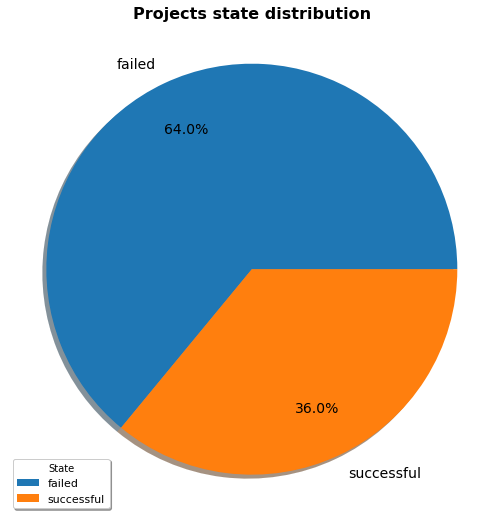

In [11]:
# Visualize the distribution of successful/failed projects in a pie

pie_ax = kickstar['state'].value_counts(normalize=True).plot.pie(figsize=(9,9),
                                                              legend=True,shadow=True, autopct='%1.1f%%' ,
                                                              pctdistance=0.75, radius=1.05, 
                                                            wedgeprops = {'linewidth': 0.1}, 
                                                              textprops = {'fontsize': 14})

pie_ax.set_title('Projects state distribution', fontsize=16, weight='bold')
pie_ax.legend(fancybox=True, shadow=True, title='State', fontsize=11)
pie_ax.set_ylabel("")
plt.show()

Summary: There are 64% failed projects and 36% successful projects in the dataset. It is a good split for future analysis.

### Q1:  Any correlation among numerical variables that would affect our model?

                  usd_pledged_real  usd_goal_real   backers  duration  \
usd_pledged_real          1.000000       0.005638  0.753399  0.000916   
usd_goal_real             0.005638       1.000000  0.004542  0.004194   
backers                   0.753399       0.004542  1.000000 -0.000809   
duration                  0.000916       0.004194 -0.000809  1.000000   
year                      0.022562       0.013107  0.016687 -0.036734   
name_length               0.028642      -0.003826  0.020174  0.008477   

                      year  name_length  
usd_pledged_real  0.022562     0.028642  
usd_goal_real     0.013107    -0.003826  
backers           0.016687     0.020174  
duration         -0.036734     0.008477  
year              1.000000    -0.053637  
name_length      -0.053637     1.000000  


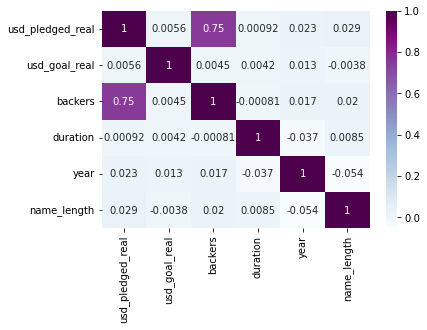

In [12]:
#check for any correlation among float variables 
correlation_x = kickstar[['usd_pledged_real','usd_goal_real','backers', 'duration', 'year', 'name_length']]
print(correlation_x.corr())

# From the result, we could see that backers are highly correlated to usd_pledged_real 75.3%
# we propose the reasoning that if the project has more backers, it would have higher usd pledged value. 

# plot the correlation matrix
sns.heatmap(correlation_x.corr(), annot = True, cmap = "BuPu")
plt.show()

Summary: From the result, we could see that backers are highly correlated to usd_pledged_real 75.3%

### Q2: Among all categories, which category has the most successful project?

Text(0.5, 1.0, 'Successful Projects in Categories')

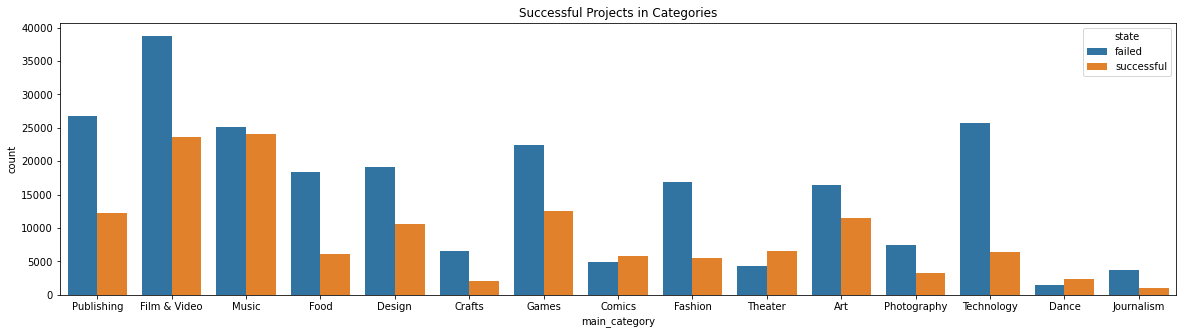

In [13]:
# count for number of successful proejcts v.s. failed projects in each category
plt.figure(figsize=(20, 5))
sns.countplot(x='main_category', data=kickstar, hue='state').set_title('Successful Projects in Categories')

Summary: From the result, we could see that Music, Film & Video, Games have the most successful projects.

## Q4 Which category has the highest pledged over goal rate?
In the dataset setting, the successful project is defined as having pledged value met by its goal. However, We think that a successful project should have enough "pledged value" funding to support its execution.

Thus, we are interested in learning what project category has the largest percent of pledge over goal rate. 

In this case, we rank different categories in respect to their pledge over goal rate. The project owner may get an average sense of the possibility that its project would be successful on the kickstar platform.

In [55]:
# find out the pledged over goal rate for each category

pledge_median = (kickstar.groupby(kickstar["main_category"]).median()[["usd_goal_real"]].reset_index())
pledge_median = pledge_median.sort_values(by=["usd_goal_real"], ascending=False)

goal_median = (kickstar.groupby(kickstar["main_category"]).median()[["usd_pledged_real"]].reset_index())
goal_median = goal_median.sort_values(by=["usd_pledged_real"], ascending=False)

goal_vs_pledged = goal_median.merge(pledge_median, how="outer", on="main_category")

In [56]:
goal_vs_pledged["pledged_minus_goal"] = (goal_vs_pledged["usd_pledged_real"] 
                                         - goal_vs_pledged["usd_goal_real"])

goal_vs_pledged["pledged_over_goal_rate"] = (goal_vs_pledged["usd_pledged_real"] / 
                                             goal_vs_pledged["usd_goal_real"])

goal_vs_pledged =goal_vs_pledged.sort_values(by=["pledged_over_goal_rate"], ascending=False)

goal_vs_pledged.style.bar(
    subset=[
        "usd_goal_real",
        "usd_pledged_real",
        "pledged_minus_goal",
        "pledged_over_goal_rate",
    ],
    align="mid",
    color=["#d65f5f", "#5fba7d"],
)

,main_category,usd_pledged_real,usd_goal_real,pledged_minus_goal,pledged_over_goal_rate
0,Dance,1855.000000,3300.000000,-1445.000000,0.562121
2,Theater,1561.000000,3268.940000,-1707.940000,0.477525
3,Comics,1500.000000,3500.000000,-2000.000000,0.428571
5,Music,1004.000000,4000.000000,-2996.000000,0.251000
1,Design,1846.640000,10000.000000,-8153.360000,0.184664
4,Games,1248.000000,8000.000000,-6752.000000,0.156000
7,Art,425.670000,3000.000000,-2574.330000,0.141890
6,Film & Video,760.000000,6938.830000,-6178.830000,0.109529
12,Photography,240.000000,4000.000000,-3760.000000,0.060000
9,Publishing,290.820000,5000.000000,-4709.180000,0.058164


### EDA Conclusion
1) From the correlation result, we could see that backers are highly correlated to usd_pledged_real 75.3%. We propose the reasoning that if the project has more backers, it would have higher usd pledged value. In the next step, we will avoid the problem of collinearity by removing "pledged_value" column

2) We detect that Music category has the most successful projects, and so does its successful rate. We  recommend music project owner to crowdfund on the kickstar platform. Their projects seem to have greater probability to be successful according to the exploratory data.

4) We see that Dance category has the highest pledged over goal rate. We assume that dance project owners de-value its projects, but those projects are intriguing to the public. Thus, we may recommend Dance, theatre, and comic projects owners to be more confident on their projects' goal value, they may win more than they expected.

### EDA Part ll

In addition to this, we also interested in seeing: 

- which country has the most successful projects

- 1) what is the median number of backers for the category, 
- 2) what is the average duration of project for the category, 
- 3) what is the average length of project's name for the category, 
- 4) what is the median pledge and goal value for the category.

The purpose for doing so is to help the project owner gets an average sense of what is his project's category should have in terms of backers, duration, length of project's name, pledge and goal value on the kickstar platform.

Text(0.5, 1.0, 'Successful Projects in Countries')

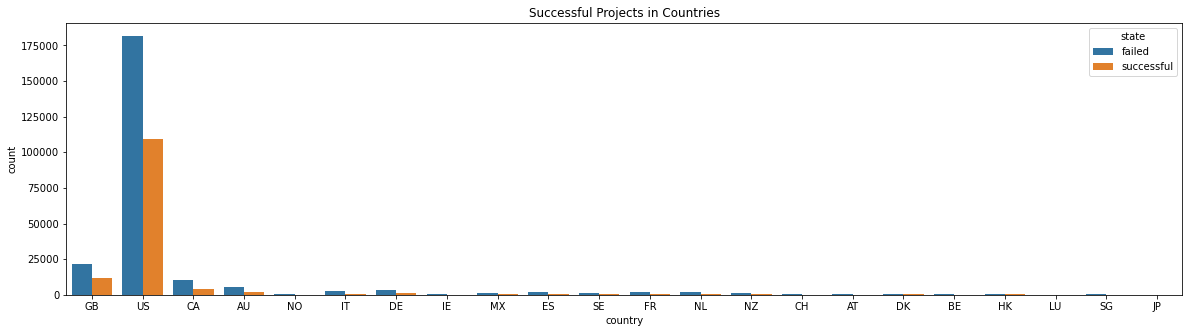

In [15]:

# count for number of successful proejcts v.s. failed projects in each country
plt.figure(figsize=(20, 5))
sns.countplot(x='country', data=kickstar, hue='state').set_title('Successful Projects in Countries')

Summary: country U.S. has the most successful projects, but not the successful rate. It is understandable because Kickstar is an American website, there are more american people using the website rather than european people.

In [16]:
# Find out the median backers for each category
backers_median = kickstar.groupby(["main_category"]).median()['backers'].reset_index()
backers_median = backers_median.sort_values(by=["backers"], ascending=False)

backers_median.style.bar(subset=["backers"], align="mid", color=["#5fba7d"])

,main_category,backers
1,Comics,40.000000
8,Games,30.000000
4,Design,29.000000
3,Dance,27.000000
14,Theater,25.000000
10,Music,19.000000
6,Film & Video,12.000000
0,Art,10.000000
12,Publishing,7.000000
13,Technology,7.000000


In [17]:
# Find out the avergae duration for each category
duration_mean = kickstar.groupby(["main_category"]).mean()['duration'].reset_index()
duration_mean = duration_mean.sort_values(by=["duration"], ascending=False)

duration_mean.style.bar(subset=["duration"], align="mid", color=["#5fba7d"])

,main_category,duration
10,Music,35.795488
6,Film & Video,35.772818
13,Technology,35.385925
14,Theater,34.950511
4,Design,34.922550
9,Journalism,34.530807
12,Publishing,34.383598
1,Comics,34.118496
7,Food,34.017202
11,Photography,33.823392


In [18]:
# Find out the avergae name length for each category
name_length_mean = kickstar.groupby(["main_category"]).mean()['name_length'].reset_index()
name_length_mean = name_length_mean.sort_values(by=["name_length"], ascending=False)

name_length_mean.style.bar(subset=["name_length"], align="mid", color=["#5fba7d"])

,main_category,name_length
4,Design,39.263835
13,Technology,37.635824
14,Theater,36.893938
10,Music,36.656034
12,Publishing,36.496853
3,Dance,36.076554
5,Fashion,35.570561
0,Art,34.593211
11,Photography,34.469618
7,Food,34.110665


In [19]:
# Find out the median goal value for each category
pledge_median = pledge_median.sort_values(by=["usd_goal_real"], ascending=False)

pledge_median.style.bar(subset=["usd_goal_real"], align="mid", color=["#5fba7d"])

,main_category,usd_goal_real
13,Technology,20000.000000
4,Design,10000.000000
7,Food,10000.000000
8,Games,8000.000000
6,Film & Video,7000.000000
5,Fashion,5938.520000
9,Journalism,5000.000000
12,Publishing,5000.000000
10,Music,4000.000000
11,Photography,4000.000000


In [20]:
# Find out the median goal value for each category
goal_median = (kickstar.groupby(kickstar["main_category"]).median()[["usd_pledged_real"]].reset_index())
goal_median = goal_median.sort_values(by=["usd_pledged_real"], ascending=False)

goal_median.style.bar(subset=["usd_pledged_real"], align="mid", color=["#5fba7d"])

,main_category,usd_pledged_real
4,Design,1925.700000
3,Dance,1855.000000
14,Theater,1552.550000
1,Comics,1501.720000
8,Games,1303.125000
10,Music,1003.000000
6,Film & Video,755.000000
0,Art,426.000000
13,Technology,322.000000
12,Publishing,291.000000


## Feature Enginnering 
In this section, we want to prepare features for our model selection part. 
- 1) we examine is there any outliers that may affect our result / recommendation to project owners
- 2) we perform OHE on categorical data: country, main_category
- 3) we examine is there any unnecessary data that may affect us to grasp useful information

### part I remove outliers

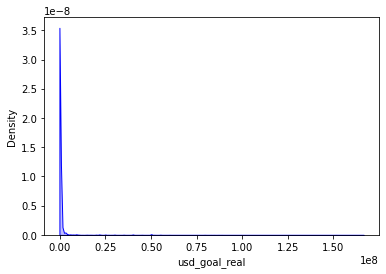

In [21]:
# Consider potential problem of outliers - Yes. Outliers exist
# we plot to see how var usd_pledged_real is distributed.
# we could see from this distribution that it is right skewed with a sipke at 0 - 0.2*10^7
fig = sns.kdeplot(kickstar['usd_goal_real'], shade=True, color="b")

plt.show()

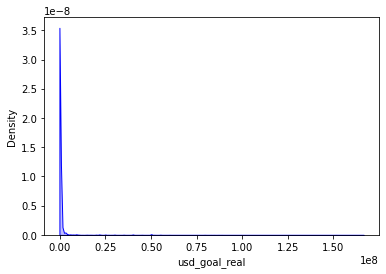

In [22]:
# we plot to see how var usd_goal_real is distributed.
# we could see from this distribution is right skewed, with a spike at 0 - 0.1*10^8.
fig = sns.kdeplot(kickstar['usd_goal_real'], shade=True, color="b")

plt.show()

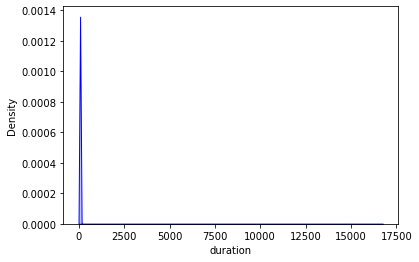

In [23]:
# we plot to see how var duration is distributed.
fig = sns.kdeplot(kickstar['duration'], shade=True, color="b")

plt.show()

In [24]:
#We want to remove ouliers displayed in the above graphs.
#We'll only use the values distributed in 3 std range - keep 99.5% of the data
#We do the oulier clean based on duration, usd_goal_real and usd_pledged_real

#mean and std
data_mean, data_std = mean(kickstar['usd_goal_real']), std(kickstar['usd_goal_real'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# remove outliers
after_outliers_removed_boolean = [(x >= lower and x <= upper) for x in kickstar['usd_goal_real']]
#update df based on boolean
kickstar = kickstar[after_outliers_removed_boolean]


370248

In [ ]:
#repeat for duration and usd_pledged_real
data_mean, data_std = mean(kickstar['usd_pledged_real']), std(kickstar['usd_pledged_real'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
after_outliers_removed_boolean = [(x >= lower and x <= upper) for x in kickstar['usd_pledged_real']]
kickstar = kickstar[after_outliers_removed_boolean]

data_mean, data_std = mean(kickstar['duration']), std(kickstar['duration'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
after_outliers_removed_boolean = [(x >= lower and x <= upper) for x in kickstar['duration']]
kickstar = kickstar[after_outliers_removed_boolean]

len(kickstar)

### part ll perform OHE on categorical variables

In [25]:
# one hot coding transformation on main_category variable
OHEmain_cate = pd.get_dummies(kickstar.main_category, prefix='main_category')

# 15 columns added to the dataset
OHEmain_cate.columns

Index(['main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

In [26]:
frames = [kickstar, OHEmain_cate]
kickstar_update = pd.concat(frames, axis=1)

# OHE updated dataset, with one OHE var transformed
kickstar_update
kickstar_update.columns
len(kickstar_update.columns) 

31

In [27]:
# one hot coding categorical var transformation on country
OHEcountry = pd.get_dummies(kickstar.country, prefix='country')
len(OHEcountry.columns) # there are 22 columns created for OHE country

22

In [28]:
# OHE updated dataset, with two OHE var transformed
frames_2 = [kickstar_update, OHEcountry]
kickstar_update_3 = pd.concat(frames_2, axis=1)
kickstar_update_3.columns
len(kickstar_update_3.columns) # 15+22 = 37 columns

53

In [29]:
kickstar_update_3.columns

Index(['ID', 'name', 'main_category', 'currency', 'deadline', 'launched',
       'state', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real',
       'trans_launched', 'trans_deadline', 'duration', 'year', 'name_length',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtyp

### Part lll remove unnecessary data that may affect us to grasp useful information
- remove ID, Name, currency, deadline, launched, trans_launched(helper), trans_deadline(helper), usd_pledged_real, country, main_category

In [30]:
# feature select for data mining
feature_select = kickstar_update_3[['backers', 'usd_goal_real',
       'duration', 'name_length','year','state',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US']]

len(feature_select.columns)

43

## Data Report Summary 
In the Feature engineering section,
- 1) we removed outliers in duration, usd_pledged_value, usd_goal_value, and keep the 99.5% of the data. We think that large outliers may lead to a skewed result, and affect our average value conclusion for project owners.
- 2) we transformed categorical variable by OHE. By doing so, we have 37 extra columns, but we made the categorical variable operatable in the model.
- 3) we remove some unnecessary varibales, which either are helper columns in previous steps, or mean little things in interpretting the result. 

### Dataset report
- columns number:43, row number: 370248

### variable properties

- Name length: Length of the project name (integer)

- Main Category (categorical): Main Category of creative projects on Kickstarter. - OHE
    
- Duration: Duration of the project (integer) : days
    
- Year: Year of the project (float)

- USD_Goal_real (numerical): Fundraising goal, the amount of money a creator needs to complete their Projects (in USD dollars).

- State (categorical): Current condition of the project (fail/successful).

- Backers (numerical): Number of backers (sponsors).

- Country (categorical): Country the pledge is from. - OHE

##  Model Selection and Model Validation

### Methodology
In the Data mining section, we experienced with four models, which are KNN, decision Tree, Gaussian and Random Forest. We keep KNN, Gaussian model and Random Forest Tree models in our final delivery, because Decision Tree model has large variance and it is unstable in terms of the result. 

In this section, We are interested in learning which model has the best performace helping project owners to make good prediction (classification). 

### Best model determinant: 
Precision score. 
Since a flase positive classification makes project owners think that its project can be successful and devote lots of efforts and money to it, but actually it is not a successful project. We consider this case is very costly to the project owners. Therefore, we maximize precision score. Increasing the possibility of true positives among positives in choosing the model. 

### Model Validation: 
After using cross validation to test the model and tune the parameter. Gaussian model improves its precision a lot, it yields a 89.69% of precision in final model. Random Forest also provides a 89.77% of precision. In this case, we decide to use the Random Forest model. Reasoning below.

Summary for every model is provided below.

### Model selection: 
Random Forest

In [31]:
# split the original dataset into train and test
predictors = kickstar_update_3[[
        'backers', 'usd_goal_real',
       'duration', 'name_length','year',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US']]

target = (kickstar_update_3['state']=='successful')

X_train, X_test, y_train, y_test = train_test_split(predictors,target,
                                                    test_size=0.2,
                                                    random_state=1)

### KNN model - PCA 

In [32]:
# PCA reduce dimension
pca = PCA(n_components=2, svd_solver='full')
pca.fit(predictors)
PCA(n_components=2, svd_solver='full')
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.99992247e-01 7.71342547e-06]
[62439956.77708472   173415.50349296]


In [33]:
principalComponents = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

X_train_pca

,principal component 1,principal component 2
0,76406.963691,80.270987
1,-21093.011915,471.347847
2,-20593.043626,-28.613971
3,-20593.046589,-75.592269
4,-18593.041722,3.289944
...,...,...
296193,376406.953470,-86.667072
296194,-22066.069898,32.429071
296195,-21593.045010,-51.546163
296196,-22794.203780,-35.525965


In [34]:
# transform the data
principalComponents = pca.fit_transform(X_test)
X_test_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])


[[43232  2659]
 [ 4448 23711]]
Precision: 0.8420398451649561


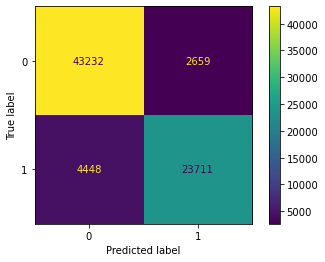

In [35]:
# train the model
knn = KNeighborsClassifier()

y_pred = knn.fit(X_train_pca, y_train).predict(X_test_pca)

scores_knn = metrics.precision_score(y_test,y_pred)

#print out confusion matrix
cm_state_knn= confusion_matrix(y_test,y_pred).T
print(cm_state_knn)

dissplay_cm_state_knn= ConfusionMatrixDisplay(confusion_matrix=cm_state_knn, display_labels=None)
dissplay_cm_state_knn.plot()

#print out the accuracy score
print("Precision: "+str(metrics.precision_score(y_test, y_pred)))

In [36]:
# tune the hyperparameter k
# i is the number of neighbor, and score stores the accuracy of the model
cross_val = KFold(n_splits=10, random_state=None, shuffle=False)
precision = []

for i in range(1,11): # get 10 possible points for neighbors 

    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train_pca, y_train)
    scores = cross_val_score(model, X_train_pca, y_train, scoring="precision", cv=cross_val, n_jobs=2)
    precision.append(scores.mean())
    print("CV precision of k = "+str(i)+" is: "+str(scores.mean()))

CV precision of k = 1 is: 0.849706635639604
CV precision of k = 2 is: 0.9018160662219954
CV precision of k = 3 is: 0.8715526837868509
CV precision of k = 4 is: 0.8962997124924664
CV precision of k = 5 is: 0.8778607182541867
CV precision of k = 6 is: 0.8946595577948093


/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV precision of k = 7 is: 0.8808996196735535
CV precision of k = 8 is: 0.8933477610275746


/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV precision of k = 9 is: 0.8824721624684668
CV precision of k = 10 is: 0.8923635656060318


[[45354  7245]
 [ 2326 19125]]
Precision: 0.891566826721365


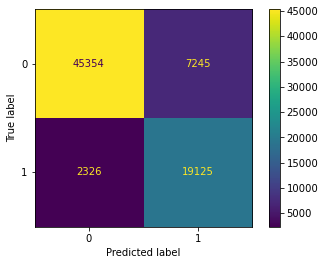

In [37]:
# train a KNN model neighbor = 2

knn = KNeighborsClassifier(n_neighbors=2) 

y_pred = knn.fit(X_train_pca, y_train).predict(X_test_pca)

scores_knn = metrics.precision_score(y_test,y_pred)

#print out confusion matrix
cm_state_knn= confusion_matrix(y_test,y_pred).T
print(cm_state_knn)

dissplay_cm_state_knn= ConfusionMatrixDisplay(confusion_matrix=cm_state_knn, display_labels=None)
dissplay_cm_state_knn.plot()

#print out the accuracy score
print("Precision: "+str(metrics.precision_score(y_test, y_pred)))

### Summary for KNN model

KNN model yields a 84.20% precision score before tunning the model. It is a fair measure, but it is not good enough. Thus,we use the cross validation method, looking for hyperparameter k-neighbor in [1-10] for the highest precision score. After computation, we found out that k = 2 gives the highest precision among 10 choices, and thus, we tune the parameter and increase its precision score to 89.16%. From the matrix, we lower the FP to 2326 cases.

### Gaussian Model

[[40874 10456]
 [ 6806 15914]]
precision: 0.7668872383524645
              precision    recall  f1-score   support

       False       0.80      0.86      0.83     47680
        True       0.70      0.60      0.65     26370

    accuracy                           0.77     74050
   macro avg       0.75      0.73      0.74     74050
weighted avg       0.76      0.77      0.76     74050



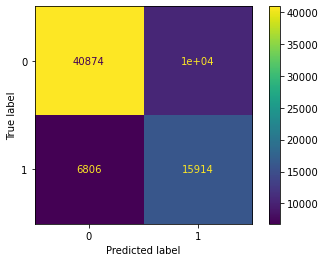

In [38]:
# Use GNB to find preicision score of the original model
gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)

#find the accuracy score
scores_gnb = metrics.accuracy_score(y_test,y_pred)

#print out confusion matrix
cm_state_gnb = confusion_matrix(y_test,y_pred).T
print(cm_state_gnb)

dissplay_cm_state_gnb= ConfusionMatrixDisplay(confusion_matrix=cm_state_gnb, display_labels=None)
dissplay_cm_state_gnb.plot()

#print out the accuracy score
print("precision: "+str(metrics.accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

In [39]:
# tune the parameter of var_smooth based on the CV score of training dataset

var_smooth = list(np.logspace(0,-9, num=10))
cross_val = KFold(n_splits=10, random_state=None, shuffle=False)

precision = []
for i in range(10):
    gnb = GaussianNB(var_smoothing = var_smooth[i])
    model = gnb.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring="precision", cv=cross_val, n_jobs=2)
    precision.append(scores.mean())
precision

/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bellalu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarnin

[0.0,
 0.38005632035499437,
 0.3894857893414617,
 0.391853757148215,
 0.3925674355607124,
 0.40215316367197157,
 0.4314436821384353,
 0.9015170051619377,
 0.8031514634812547,
 0.7043111639935292]

In [40]:
var_smooth

[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]

0.8969426091462624
[[46089 12523]
 [ 1591 13847]]
              precision    recall  f1-score   support

       False       0.79      0.97      0.87     47680
        True       0.90      0.53      0.66     26370

    accuracy                           0.81     74050
   macro avg       0.84      0.75      0.76     74050
weighted avg       0.83      0.81      0.79     74050



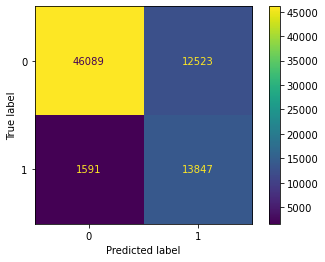

In [41]:
#Based on the graph and accuracy report, I choose var smoothing to be 1e-07
gnb = GaussianNB(var_smoothing = 1e-07)
gnb = gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

scores = metrics.precision_score(y_test,y_pred)
print(scores)

cm = confusion_matrix(y_test,y_pred).T
print(cm)
print(classification_report(y_test, y_pred))
dissplay = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
dissplay.plot()

### Summary for Gaussian Model
Gaussian model yields a 76.78% precision score before tunning the model. It is a fair measure, but it is not good enough. Thus, we use the cross validation method, looking for hyperparameter var_smooth [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09] that can give us the highest precision score. After computation, we found out that 1e-07 gives the highest precision among 10 choices, and thus, we tune the parameter and increase its precision score to 89.69. From the matrix, we lower the FP to 1591 cases.

### Random Forest Model

[[44953  2412]
 [ 2727 23958]]
Precision: 0.8978077571669477


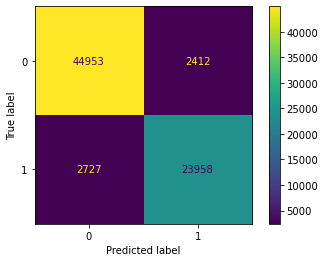

In [42]:
rfc = RandomForestClassifier()

y_pred = rfc.fit(X_train, y_train).predict(X_test)

#find the accuracy score
scores_rfc = metrics.precision_score(y_test,y_pred)

#print out confusion matrix
cm_state_rfc= confusion_matrix(y_test,y_pred).T
print(cm_state_rfc)

dissplay_cm_state_rfc= ConfusionMatrixDisplay(confusion_matrix=cm_state_rfc, display_labels=None)
dissplay_cm_state_rfc.plot()

#print out the accuracy score
print("Precision: "+str(metrics.precision_score(y_test, y_pred)))

In [44]:
# tune the parameter of max_feature
# max number of feature in random forest should equal to the square root of number of features

max_feature = [7,8,9]

cross_val = KFold(n_splits=5, random_state=None, shuffle=False)

precision = []
for i in range(3):

    rfc = RandomForestClassifier(max_features = max_feature[i], max_depth = 100)
    model = rfc.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring="precision", cv=cross_val, n_jobs=2)
    precision.append(scores.mean())
precision

# it takes super long time to tune the parameter, and it takes even longer time to tune with max depth
# so, we only tune one parameter max_feature.
# But luckily, we could see some improvements on the result

[0.8999740042552198, 0.8996544171368814, 0.9005354143214793]

[[44951  2355]
 [ 2729 24015]]
Precision: 0.897958420580317


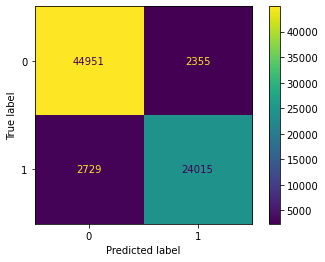

In [45]:
# validate the model 
rfc = RandomForestClassifier(max_features = 9, max_depth = 100)

y_pred = rfc.fit(X_train, y_train).predict(X_test)

#find the accuracy score
scores_rfc = metrics.precision_score(y_test,y_pred)

#print out confusion matrix
cm_state_rfc= confusion_matrix(y_test,y_pred).T
print(cm_state_rfc)

dissplay_cm_state_rfc= ConfusionMatrixDisplay(confusion_matrix=cm_state_rfc, display_labels=None)
dissplay_cm_state_rfc.plot()

#print out the accuracy score
print("Precision: "+str(metrics.precision_score(y_test, y_pred)))

### Summary for Random Forest Model
Random Forest model yields a 89.69% precision score before tunning the model. It is a good measure, but we want to see whether we can improve this number. We used the grid research, trying to tune n_estimators, max_features, max_depth, min_sample_split, min_sample_leaf, and bootstrap. However, the dataset is too big and there are too many dimensionalities involved, the grid research is not working well in this case.

We consider max_feature is the most influential hyperparameter among all, so we tune the max_feature by [7,8,9] - max_feature should be square root of number of features, and the max_depth =  100. Finally, we improve our model a little. The final precision score is 89.78%.

### Final model Random Forest: Finding on FP

In [46]:
# see all flase positives

y_test_list = list(y_test)
y_pred_list = list(y_pred)

# create a false positive dataframe
False_positive = []

for i in range(len(y_test)):
    if (y_test_list[i] == False) and (y_pred_list[i]== True):
        False_positive.append(i)
#print(False_positive)

In [47]:
# create a dataframe of false positives
final_list = [kickstar_update_3.iloc[i] for i in False_positive]
list_of_false_positive = pd.DataFrame(final_list)
len(list_of_false_positive)

2729

**As you see in the above steps, list_of_false_positive is a list containing all of the false positive samples(FP). Since FP is the most costly error in our case, we want to dig deeper to figure out which kind of features are more likely to have the FP issue in the RF model. Thus, we use associaton rule in the list_of_false_positive samples.**

In [48]:
# see which category and country is most likely get a false positive misclassification in prediction
df = list_of_false_positive[['main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US']]

In [49]:
# Use association rule
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.171858,(main_category_Film & Video),1
1,0.141077,(main_category_Music),1
2,0.109564,(main_category_Publishing),1
3,0.798095,(country_US),1
4,0.145841,"(main_category_Film & Video, country_US)",2
5,0.128985,"(main_category_Music, country_US)",2


### Final model Random Forest: Finding on nodes importance

In [50]:
# find out feature importance
from matplotlib import pyplot
importance = rfc.feature_importances_

k = []
for i,v in enumerate(importance):
    k.append((predictors.columns[i], v))

#print(k)

l = sorted(k, key=lambda x: x[1], reverse = True)
pd.DataFrame(l)

,0,1
0,backers,0.639847
1,usd_goal_real,0.174696
2,name_length,0.055007
3,duration,0.042249
4,year,0.028305
5,main_category_Games,0.006742
6,main_category_Music,0.005979
7,main_category_Technology,0.004457
8,main_category_Design,0.003867
9,main_category_Film & Video,0.003837


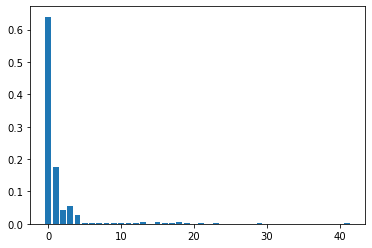

In [51]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Conclusion

### Among all three models, we believe that the Random Forest is the best model among all. 
 - 1) It has the highest precision score. It lowers the chance that projects being misclassified as flase positive - reduce the cost for having a Type I error in prediction.
 - 2) It ranks the features importance to the outcome. 
 - 3) It uses different random subsets of features at each split creates different, less correlated trees (less variance compared to decision tree model).
 
### In Random Forest prediction result, Film &Video category is most likely be misclassified as false positive among all categories.
 - Among 2755 flase positives, there are 469 projects that are film&video (17%), which is most likely be misclassified as false positive. The second and the third category are Music and Publishing. In this case, we suggest projects' owners of these three categories be really careful when the model gives them a positive, because their false positive results appear to be more frequently occurred than other projet categories. 

 ### Informative features are backers (0.64), usd_goal_real(0.172), and name_length (0.055)
- In the RF model, the most informative features are bakers, usd_goal_real and name_length. They are informative in determining the success of the project. We suggest all project owners on kickstar website to pay attention to these three features, and compare their projects' features to the category average, and make proper adjustment on these three features.

## Future Work

- 1)We once tried to answer the question, "What are the characteristics of the project that will get funded (successful)?" We used a decision tree model to address this. 
    
    However, the DTC model has high variance, and thus we used the Random Forest model instead. Though the RF model achieves lower variance than DTC, it is tough to interpret due to its nature. RF model uses random subsets of features at each split and creates different, less correlated trees. We can understand how a single tree works on splitting, but it's so hard to combine the split rules of many trees together. 

    We address the initial DTC idea in the next section. In future work, we want to find a good model for    interpreting the successful features while maintaining the variance-bias balance.

- 2) We found our dataset is highly imbalanced since we have too many samples belonging to country_US. We consider that the imbalance of the feature may raise the likelihood of bias. We will work on some ideas to balance the dataset in the future. For example, we may reduce the number of samples with the feature country_US and distribute all pieces evenly across countries.

- 3) Currently, we used the length of project name, we can also use NLP to get useful infromation from Project's names.

## Decision Tree Model

**Using Decision Tree Algorithm to interpret the feature importance and figure out the pattern indicating the characteristics that able to make a successful product.**

DTC model is built from the idea of recursively partitioning the training examples into purer sub groups. Each branch of the tree model uses a sequence of features to classify the target variable. Therefore, by summarizing the classification rule of each tree's branch and combining the individual likelihood into a big pattern, we can let people know which set of features may more likely to cause a specific outcome.

The codes in the two blocks below were created by Winson Waisakurnia. He is a data scientist who write monthly articles in https://towardsdatascience.com/. His two methods work as efficient tools to gather the likelihood of each tree branch and then summarize them togther. We put reference of the two methods in the final part of this notebook. Please have a check.

In [52]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
                # register new rule to dictionary
                selected_class = classes[max_idx]
                class_probability = dist[max_idx]
                class_rules = class_rules_dict.get(selected_class, [])
                class_rules.append((rule_string, class_probability))
                class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

In [53]:
def classification_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [54]:
classification_report(predictors, target)

,class_name,instance_count,rule_list
0,False,237802,[0.8974752553855926] (backers <= 17.5) and (usd_goal_real <= 758.8650207519531) and (backers <= 5.5)[0.973615075799793] (backers <= 17.5) and (usd_goal_real > 758.8650207519531)[0.8376201434953296] (backers > 17.5) and (usd_goal_real > 8151.81005859375) and (backers <= 85.5)
1,True,132446,[0.7657209710441649] (backers <= 17.5) and (usd_goal_real <= 758.8650207519531) and (backers > 5.5)[0.8570917959715739] (backers > 17.5) and (usd_goal_real <= 8151.81005859375)[0.7810836126996648] (backers > 17.5) and (usd_goal_real > 8151.81005859375) and (backers > 85.5)


### Explanation

As you can see in the rule_list column, the content is formed by a likelihood ([0.8974752553855926]] for the first item) and a set of corresponding conditions (((usd_goal_real <= 758.8650207519531) and (backers <= 5.5)) for the first item). To interpret this, it means if a product has less than or equal to 5.5 backers, and requires a usd_goal less than or equal to 758.8650207519531, then the product has 89.74752553855926% likelihood to be failed (False as the class_name of the first column).

Based on this report, a product owner or a potential investor may able to easily predict the final status of the product before its real launch.

# References
- One hot encoding: Machine learning handbook, chapter 2
https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
- data visualization: HW1
- cleaning the data: Applied midterm, HW2
- decision tree classifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
Course lecture slides
- dtc feature importance:
https://machinelearningmastery.com/calculate-feature-importance-with-python/
- clustering code:
https://towardsdatascience.com/the-easiest-way-to-interpret-clustering-result-8137e488a127
- Type I Type II error:
https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e
- outlier:
https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/